# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework 10
**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, April 13th, 2018 at 10:59am

**Instructions:**

- Upload your final answers as an iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

In [1]:
import numpy as np
import pandas as pd
import time
from collections import Counter
from sklearn.model_selection import train_test_split
from scipy.special import expit

import pymc3 as pm
import theano.tensor as T

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('talk')
%matplotlib inline

## Problem #1: Iris Eyes Are Smiling

This Homework problem is a continuation of Problem #4 from Homework 8.  We'll be using the same iris dataset. The iris data can be obtained [here](./iris.csv).

Now that we have from Homework 8 Problem #4 a train-test split as well as point estimate(s) and a posterior distribution on the probability of a data point being virginica, we can use these to make predictions on both the training set and test set.

** *Note this next section is just guidance and doesn't contain any work for you to do* **

*There are two ways to make these predictions, given an estimate of $p(y=1\ \vert\ x)$:* 

(A) You can sample from the Bernoulli likelihood at the data point $x$ to decide if that particular data points classification $y(x)$ should be a 1 or a 0.

(B) Or you could do the intuitive "machine-learning-decision-theoretic" (MLDT) thing, where you assign a data  point $x$ a classification 1 if $p(y=1 \vert x) > 0.5$.

*There are multiple ways in which you can do these probability estimates at a sample $x$:*

(A) You can just use a point estimate like the MAP value, ($p_{MAP}$), or the posterior mean ($p_{MEAN}$)

(B) You can see what fraction of your posterior samples have values above 0.5 (ie you are calculating 1-cdf(0.5)) on the posterior ($p_{CDF}$))

Both these above methods miss the combined smearing of the posterior and sampling distributions. In other words they dont sample from the posterior predictive. If we draw a large number of samples from the posterior predictive distribution at a data point $x$, the fraction of 1s will give an estimate for the probability to use, $p_{PP}$, which is different from the MAP estimate, or the CDF estimate.

** *Note this next section contains the tasks we expect you to complete* **


1. Plot the distribution of $p_{MEAN}$, $p_{CDF}$, and $p_{PP}$ over all the data points in the training set. How are these different?
2. Plot the posterior-predictive distribution of the misclassification rate with respect to the true class identities $y(x)$ of the data points $x$ (in other words you are plotting a histogram with the misclassification rate for the $n_{trace}$ posterior-predictive samples) on the training set.
3. Make the same plot from the posterior, rather than the posterior predictive, by using the MLDT defined above. Overlay this plot on the previous one. That is, for every posterior sample, consider whether the data point ought to be classified as a 1 or 0 from the $p>0.5 \implies y=1$ decision theoretic prespective. Compare with your previous diagram. Which case (from posterior-predictive or from-posterior) has a wider mis-classification distribution? 
4. Is the classification at the true training data points (you can think of this as a bitstring '100101...' 90 characters long) represented in the posterior predictive trace? If so, how many times? Is it the most frequent string in the traces? Explain your conclusions.
5. Repeat 2 and 3 for the test set, i.e. make predictions. Describe and interpret the widths of the distributions?


### Answer to Problem 1

In [2]:
data = pd.read_csv('iris.csv')
data['y'] = (data['class'].values == ' Iris-virginica').astype(int)
print(data.shape)
data.head()

(150, 6)


,sepal_length,sepal_width,petal_length,petal_width,class,y
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0
2,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5.0,3.6,1.4,0.2,Iris-setosa,0


In [3]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :4].values, data['y'].values, \
                                                    test_size=0.4, stratify=data['y'].values, random_state=100)
X_train = np.concatenate((np.ones(len(X_train)).reshape(-1, 1), X_train), axis=1)
X_test = np.concatenate((np.ones(len(X_test)).reshape(-1, 1), X_test), axis=1)

In [4]:
%%time

with pm.Model() as m1:
    beta = pm.Normal('beta', mu=0, sd=10, shape=5)
    p = pm.Deterministic('p', 1 / (1 + T.exp(-T.dot(X_train, beta))))
    y_pred = pm.Bernoulli('y_pred', p=p, observed=y_train)
    
with m1:
    trace1 = pm.sample(5000, tune=2000, step=pm.NUTS(target_accept=0.95))

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta]
100%|██████████| 7000/7000 [01:59<00:00, 58.76it/s]


CPU times: user 2.36 s, sys: 2.8 s, total: 5.16 s
Wall time: 2min 7s


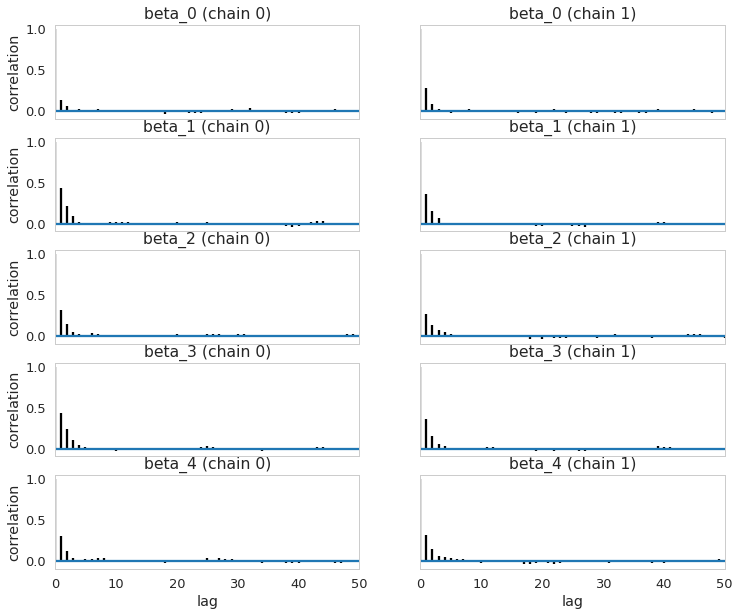

In [5]:
pm.autocorrplot(trace1, varnames=['beta'], max_lag=50);

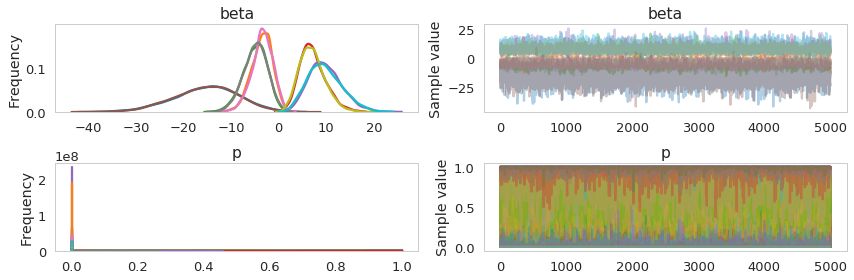

In [6]:
pm.traceplot(trace1);

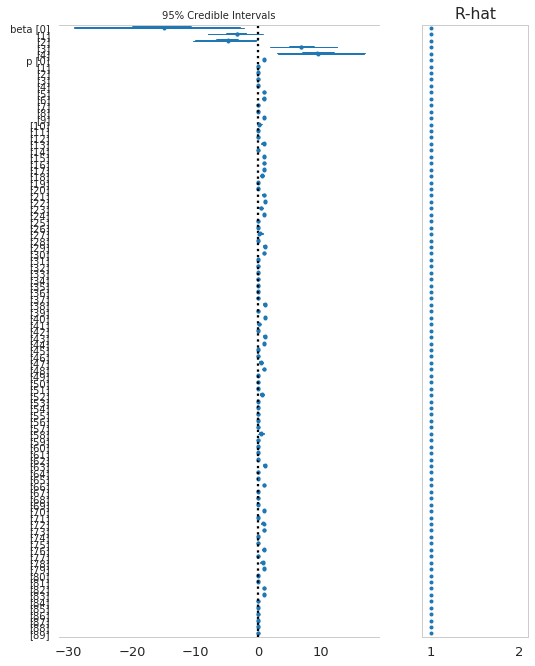

In [7]:
plt.figure(figsize=(8, 10))
pm.forestplot(trace1);

The above tests suggest that the sampler converges well.

#### 1. Plot the distribution of $p_{MEAN}$, $p_{CDF}$, and $p_{PP}$ over all the data points in the training set. How are these different?

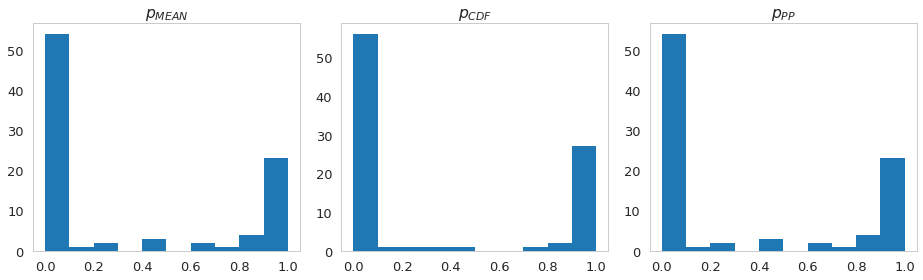

In [8]:
pp1 = np.random.binomial(1, trace1['p'])

plt.figure(figsize=(13, 4))

plt.subplot(1, 3, 1)
plt.hist(trace1['p'].mean(axis=0));
plt.title(r'$p_{MEAN}$');

plt.subplot(1, 3, 2)
plt.hist((trace1['p']>0.5).mean(axis=0));
plt.title(r'$p_{CDF}$');

plt.subplot(1, 3, 3)
plt.hist(pp1.mean(axis=0));
plt.title(r'$p_{PP}$');

plt.tight_layout();

The distributions seem to be very similar to each other. The density of bins at 2 ends (i.e., 0 and 1) seems to be higher for $P_{CDF}$, and the density of bins in between 2 ends seems to be higher for $P_{PP}$. The final sampling from likelihood for posterior predictives introduces additional uncertainty (variance) to the output compared to posteriors, resulting in slightly less points with extreme probabilities.

#### 2. Plot the posterior-predictive distribution of the misclassification rate with respect to the true class identities $y(x)$ of the data points $x$ (in other words you are plotting a histogram with the misclassification rate for the $n_{trace}$ posterior-predictive samples) on the training set.
#### 3. Make the same plot from the posterior, rather than the posterior predictive, by using the MLDT defined above. Overlay this plot on the previous one. That is, for every posterior sample, consider whether the data point ought to be classified as a 1 or 0 from the $p>0.5 \implies y=1$ decision theoretic prespective. Compare with your previous diagram. Which case (from posterior-predictive or from-posterior) has a wider mis-classification distribution?

Mean misclassification rate from posterior-predictive: 0.055097
Mean misclassification rate from posterior: 0.039547


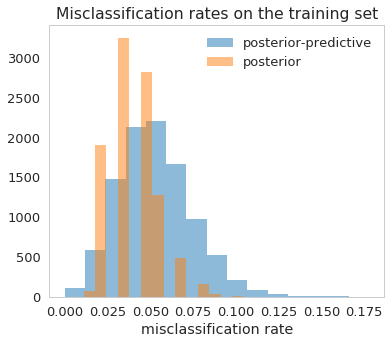

In [9]:
plt.figure(figsize=(6, 5))
plt.hist((pp1 != y_train).mean(axis=1), bins=15, alpha=0.5, label='posterior-predictive');
plt.hist(((trace1['p'] > 0.5) != y_train).mean(axis=1), bins=15, alpha=0.5, label='posterior');
plt.legend();
plt.xlabel('misclassification rate');
plt.title('Misclassification rates on the training set');

print('Mean misclassification rate from posterior-predictive: {:5f}'.format((pp1!=y_train).mean()))
print('Mean misclassification rate from posterior: {:5f}'.format(((trace1['p']>0.5)!=y_train).mean()))

The posterior-predictive case has a wider misclassification distribution. And the mean misclassification rate from posterior is lower. The final sampling from likelihood for posterior predictives introduces additional uncertainty (variance) to the predictions compared to posteriors; as a result, there are more combinations of predictions from posterior-predictives, and the misclassification distribution is wider.

#### 4. Is the classification at the true training data points (you can think of this as a bitstring '100101...' 90 characters long) represented in the posterior predictive trace? If so, how many times? Is it the most frequent string in the traces? Explain your conclusions.

In [10]:
%%time
s_train = ''.join([str(i) for i in y_train])
s_pp1 = np.array([''.join([str(i) for i in p]) for p in pp1])
s_p1 = np.array([''.join([str(i) for i in p]) for p in (trace1['p'] > 0.5).astype(int)])

c_pp1 = Counter(s_pp1)
c_p1 = Counter(s_p1)

CPU times: user 2.31 s, sys: 0 ns, total: 2.31 s
Wall time: 2.31 s


In [11]:
print('The number of perfect classification on the training set from {} posterior predictive samples: {}'\
      .format(len(s_pp1), np.sum(s_pp1==s_train)))
print('Is it the most frequent string in the traces? {}'.format(c_pp1.most_common(1)[0][0]==s_train))
print()
print('Number of unique strings: {}'.format(len(c_pp1)))
print()
print('Most frequent strings:')
c_pp1.most_common(3)

The number of perfect classification on the training set from 10000 posterior predictive samples: 8
Is it the most frequent string in the traces? False

Number of unique strings: 4879

Most frequent strings:


[('100001100100010111100110100001100000001010011000100010000010000100100010110010110011000000',
  112),
 ('100001100100010111100110100001100000001010011000100010000000000100100010110010110011000000',
  107),
 ('100001100100010111100111100001100000001010011000100010000010000100100010110010110011000000',
  85)]

In [12]:
print('The number of perfect classification on the training set from {} posterior samples: {}'\
      .format(len(s_p1), np.sum(s_p1==s_train)))
print('Is it the most frequent string in the traces? {}'.format(c_p1.most_common(1)[0][0]==s_train))
print()
print('Number of unique strings: {}'.format(len(c_p1)))
print()
print('Most frequent strings:')
c_p1.most_common(3)

The number of perfect classification on the training set from 10000 posterior samples: 0
Is it the most frequent string in the traces? False

Number of unique strings: 338

Most frequent strings:


[('100001100100010111100110100001100000001010011000100010000010000100100010110010110011000000',
  1092),
 ('100001100100010111100110100001100000001010011000100010000000000100100010110010110011000000',
  973),
 ('100001100100010111100110100001100000001010011000100010000010000100100010110010010011000000',
  559)]

The classification at the true training points is represented in the posterior predictive traces, but it is not the most frequent string in the traces. It is not represented in the posterior traces.

The fact that the perfect classification is not represented in the posterior traces indicates that there is supposed to be misclassifications on the training set for this model. The presence of perfect classifications in the posterior-predictive traces is resulted from the additional uncertainty (variance) in predictions introduced by the final sampling from the likelihood for the posterior-predictives, and thus the wider distribution of predictions. But the most frequent string is still consistent with that in predictions from posteriors, and is thus different from the true string.

#### 5. Repeat 2 and 3 for the test set, i.e. make predictions. Describe and interpret the widths of the distributions?

In [13]:
p_test = 1 / (1 + np.exp(-trace1['beta'].dot(X_test.T)))
pp_test = np.random.binomial(1, p_test)

Mean misclassification rate from posterior-predictive: 0.022422
Mean misclassification rate from posterior: 0.007697


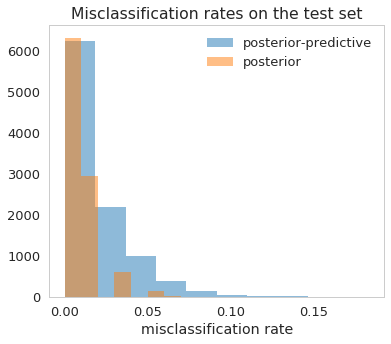

In [14]:
plt.figure(figsize=(6, 5))
plt.hist((pp_test != y_test).mean(axis=1), bins=10, alpha=0.5, label='posterior-predictive');
plt.hist(((p_test > 0.5) != y_test).mean(axis=1), bins=10, alpha=0.5, label='posterior');
plt.legend();
plt.xlabel('misclassification rate');
plt.title('Misclassification rates on the test set');

print('Mean misclassification rate from posterior-predictive: {:5f}'.format((pp_test!=y_test).mean()))
print('Mean misclassification rate from posterior: {:5f}'.format(((p_test>0.5)!=y_test).mean()))

The posterior-predictive case has a wider misclassification distribution.

The misclassification rate is very low on the test set; the model perform well on both training and test sets. The final sampling from likelihood for posterior predictives introduces additional uncertainty (variance) to the predictions compared to posteriors; as a result, there are more combinations of predictions from posterior-predictives, and the misclassification distribution is wider. 

## Problem 2: From the Ritz to the Rubble

In this problem, much like in Long Homework 9, you will explore how to recast data, tasks and research questions from a variety of different contexts so that an existing model can be applied for analysis.

Example 10.1.3 in "Statistical Rethinking", the excerpt of which is included in the data directory for this assignment, illustrates a study of the effect of an applicant's gender on graduate school admissions to six U.C. Berkeley departments through a comparison of four models. 

In this problem, you are given the data for the 1994 U.S. Census. The data has been processed so that only a subset of the features are present (for full dataset as well as the description see the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Census+Income)). You will be investigate the effect of gender on a person's yearly income in the dataset. In particular, we want to know how a person's gender effect the likelihood of their yearly salary being above or below \$50k. 

First we want to aggregate the dataset by seven different categories. The categories we wish to consider are: 
- 4 year college degree
- Some-college or two year academic college degree
- High school
- Professional, vocational school
- Masters 
- Doctorate
- Some or no high school
Note that you might have to combine some of the existing education categories in your dataframe. For each category, we suggest that you only keep track of a count of the number of males and females who make above (and resp. below) $50k (see the dataset in Example 10.1.3). 

Following Example 10.1.3, build two models for the classification of an individual's yearly income (1 being above \$50k and 0 being below), one of these models should include the effect of gender while the other should not. 

Replicate the analysis in 10.1.3 using your models; specifically, compute= wAIC scores and make a plot like Figure 10.5 (posterior check) to see how well your models fits the data. Using your analysis, discuss the effect of gender on income.

Following Example 10.1.3, build two models for the classification of an individual's yearly income taking into account education. 

Replicate the analysis in 10.1.3 using your models; specifically, compute AIC/BIC scores and make a plot like Figure 10.6 (posterior check) to see how well your model fits the data. Using your analysis, discuss the effect of gender on income, taking into account an individual's education.

### Answer to Problem 2

In [2]:
def postscat(trace, thevars):
    # reference: https://am207.github.io/2018spring/wiki/Islands2.html
    d={}
    for v in thevars:
        d[v] = trace.get_values(v)
    df = pd.DataFrame.from_dict(d)
    g = sns.pairplot(df, diag_kind="kde", plot_kws={'s':10})
    for i, j in zip(*np.triu_indices_from(g.axes, 1)):
        g.axes[i, j].set_visible(False)
    return g

def compare_models(names, traces, models):
    df = pm.compare(traces, models, method='pseudo-BMA')
    df = df.sort_index()
    df.insert(loc=0, column='name', value=names)
    df = df.sort_values('WAIC')
    df = df.set_index('name')
    return df

In [3]:
data2 = pd.read_csv('census_data.csv', index_col=0)
data2.head()

,age,sector,edu,marital,race,sex,earning
0,39,State-gov,Bachelors,Never-married,White,Male,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,White,Male,<=50K
2,38,Private,HS-grad,Divorced,White,Male,<=50K
3,53,Private,11th,Married-civ-spouse,Black,Male,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Black,Female,<=50K


In [4]:
data2['edu'].unique()

array(['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
       'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
       '5th-6th', '10th', '1st-4th', 'Preschool', '12th'], dtype=object)

In [5]:
edu2cat = {'Preschool':0,
           '1st-4th':0, 
           '5th-6th':0,
           '7th-8th':0,
           '9th':0,
           '10th':0,
           '11th':0,
           '12th':0,
           'HS-grad':1,
           'Assoc-acdm':2,
           'Some-college':2,
           'Assoc-voc':3,
           'Prof-school':3,
           'Bachelors':4,
           'Masters':5,
           'Doctorate':6}

data2['edu_cat'] = data2['edu'].apply(lambda x:edu2cat[x])
data2['is_male'] = data2['sex'].apply(lambda x:int(x=='Male'))
data2['>50K'] = data2['earning'].apply(lambda x:int(x=='>50K'))

df2 = data2.groupby(by=['edu_cat', 'is_male', '>50K']).size()\
.unstack().reset_index().rename_axis(None, axis=1)

df2.columns = ['edu_cat', 'is_male', '<=50K', '>50K']

df2['total'] = df2['<=50K'] + df2['>50K']

df2

,edu_cat,is_male,<=50K,>50K,total
0,0,0,1298,23,1321
1,0,1,2711,221,2932
2,1,0,3164,226,3390
3,1,1,5662,1449,7111
4,2,0,2974,253,3227
5,2,1,3732,1399,5131
6,3,0,483,109,592
7,3,1,691,675,1366
8,4,0,1280,339,1619
9,4,1,1854,1882,3736


#### Following Example 10.1.3, build two models for the classification of an individual's yearly income (1 being above $50k and 0 being below), one of these models should include the effect of gender while the other should not.

In [6]:
%%time

with pm.Model() as m2:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    p = pm.math.invlogit(alpha)
    obs = pm.Binomial('obs', p=p, n=df2['total'], observed=df2['>50K'])
    
    t2 = pm.sample(5000, tune=1000, step=pm.NUTS())
    
with pm.Model() as m2_gender:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    betam = pm.Normal('betam', mu=0, sd=10)
    p = pm.math.invlogit(alpha + betam * df2['is_male'])
    obs = pm.Binomial('obs', p=p, n=df2['total'], observed=df2['>50K'])
    
    t2_gender = pm.sample(5000, tune=1000, step=pm.NUTS())

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]
100%|██████████| 6000/6000 [00:04<00:00, 1280.85it/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betam, alpha]
100%|██████████| 6000/6000 [00:07<00:00, 753.66it/s]
The number of effective samples is smaller than 25% for some parameters.


CPU times: user 3.89 s, sys: 2.89 s, total: 6.78 s
Wall time: 31.1 s


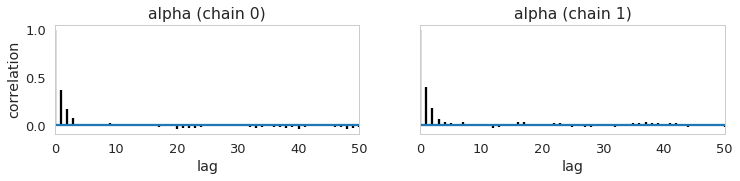

In [7]:
pm.autocorrplot(t2, max_lag=50);

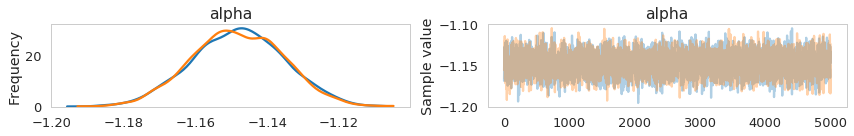

In [8]:
pm.traceplot(t2);

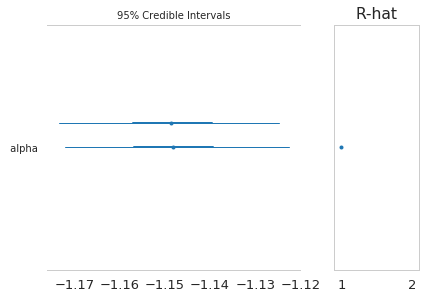

In [9]:
pm.forestplot(t2);

In [10]:
print('Effective sample sizes')
print(pm.effective_n(t2))

Effective sample sizes
{'alpha': 3994.0}


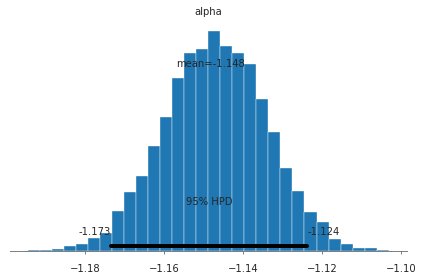

In [11]:
pm.plot_posterior(t2);

The above tests suggest the convergence of the samplers.

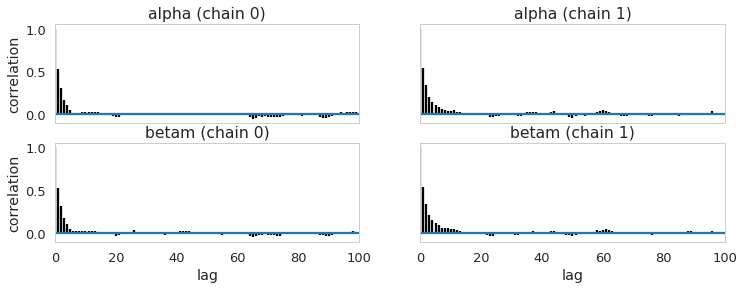

In [12]:
pm.autocorrplot(t2_gender);

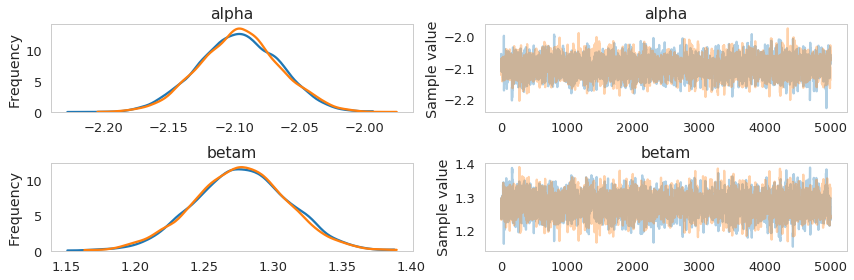

In [13]:
pm.traceplot(t2_gender);

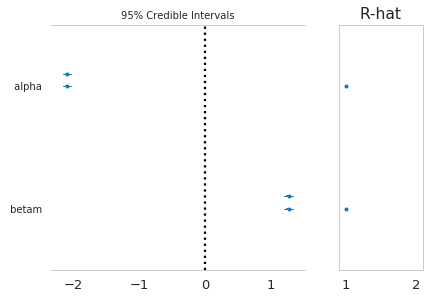

In [14]:
pm.forestplot(t2_gender);

In [15]:
print('Effective sample sizes')
print(pm.effective_n(t2_gender))

Effective sample sizes
{'alpha': 2459.0, 'betam': 2458.0}


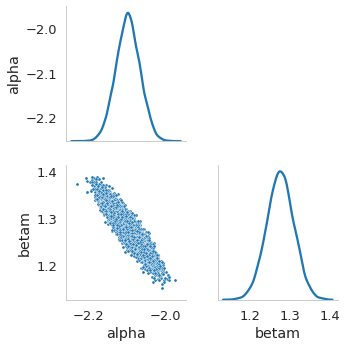

In [16]:
postscat(t2_gender, t2_gender.varnames);

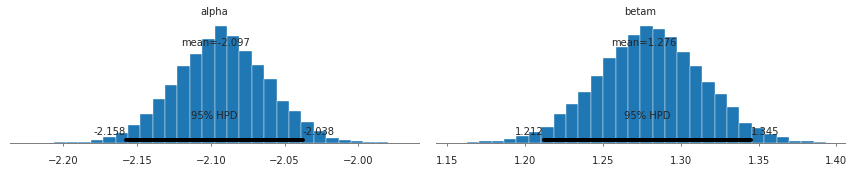

In [17]:
pm.plot_posterior(t2_gender);

The above tests suggest the convergence of the samplers.

#### Replicate the analysis in 10.1.3 using your models; specifically, compute= wAIC scores and make a plot like Figure 10.5 (posterior check) to see how well your models fits the data. Using your analysis, discuss the effect of gender on income.

In [18]:
compare_df1 = compare_models(['model_baseline', 'model_gender'], [t2, t2_gender], [m2, m2_gender])
compare_df1

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
name,,,,,,,
model_gender,4601.82,463.03,0,1,1165.27,0,1
model_baseline,6191.65,394.13,1589.83,0,1587.69,1369.4,1


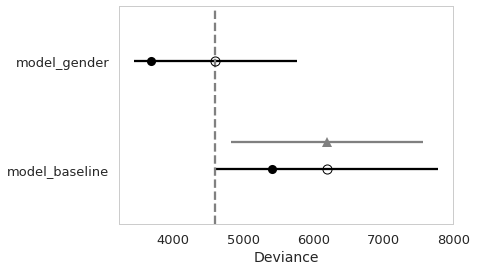

In [19]:
pm.compareplot(compare_df1);

This comparison suggests that gender matters.

In [20]:
pm.summary(t2_gender)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-2.096701,0.030789,0.000616,-2.157631,-2.037715,2459.0,1.000150
betam,1.276369,0.033905,0.000677,1.212083,1.345360,2458.0,0.999971


In [21]:
post1 = pm.trace_to_dataframe(t2_gender)

(expit(post1['alpha'] + post1['betam']) - expit(post1['alpha'])).describe(percentiles=[.025, .5, .975])

count    10000.000000
mean         0.196248
std          0.004269
min          0.179377
2.5%         0.187796
50%          0.196267
97.5%        0.204436
max          0.212138
dtype: float64

The result suggests a male advantage about 20%.

Blue points are observed proportions; black dots, the tiny vertical black lines, and the black 
crosses represent posterior means, 2-sigma envelopes for posteriors, and 2-sigma envelopes for 
normalized posterior-predictives, respectively.


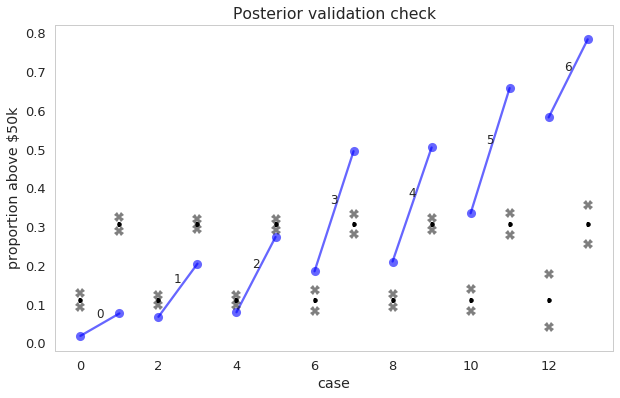

In [22]:
plt.figure(figsize=(10, 6))

for i in df2['edu_cat'].unique():
    plt.plot([2*i, 2*i+1], [df2['>50K'][2*i] / df2['total'][2*i], df2['>50K'][2*i+1] / df2['total'][2*i+1]], \
             'bo-', alpha=0.6)
    
    plt.text(2*i+0.4, (df2['>50K'][2*i] / df2['total'][2*i] + df2['>50K'][2*i+1] / df2['total'][2*i+1]) / 2 + 0.02,\
             df2['edu_cat'][2*i], fontsize=12)
    
    plt.errorbar([2*i, 2*i+1], [expit(post1['alpha']).mean(), expit(post1['alpha'] + post1['betam']).mean()], \
                 yerr=[2*expit(post1['alpha']).std(), 2*expit(post1['alpha'] + post1['betam']).std()], \
                 color='k', fmt='.');
    
    ppc_f = np.random.binomial(df2['total'][2*i], expit(post1['alpha'])) / df2['total'][2*i]
    plt.plot([2*i, 2*i], [ppc_f.mean()-2*ppc_f.std(), ppc_f.mean()+2*ppc_f.std()], 'kX', alpha=0.5)
    
    ppc_m = np.random.binomial(df2['total'][2*i+1], expit(post1['alpha'] + post1['betam'])) / df2['total'][2*i+1]
    plt.plot([2*i+1, 2*i+1], [ppc_m.mean()-2*ppc_m.std(), ppc_m.mean()+2*ppc_m.std()], 'kX', alpha=0.5)

plt.title('Posterior validation check');
plt.xlabel('case');
plt.ylabel('proportion above $50k');

print('''Blue points are observed proportions; black dots, the tiny vertical black lines, and the black 
crosses represent posterior means, 2-sigma envelopes for posteriors, and 2-sigma envelopes for 
normalized posterior-predictives, respectively.''')

The model catches the male advantage observed in data, but fails reveal the difference at different education levels. As a result, the model doesn't fit the data well.

According to the model, males are much more likely to earn more than \$50k compared to females.

#### Following Example 10.1.3, build two models for the classification of an individual's yearly income taking into account education.

In [23]:
%%time

with pm.Model() as m2_edu:
    alpha = pm.Normal('alpha', mu=0, sd=10, shape=len(df2['edu_cat'].unique()))
    p = pm.math.invlogit(alpha[df2['edu_cat']])
    obs = pm.Binomial('obs', p=p, n=df2['total'], observed=df2['>50K'])
    
    t2_edu = pm.sample(5000, tune=1000, step=pm.NUTS())
    
with pm.Model() as m2_edu_gender:
    alpha = pm.Normal('alpha', mu=0, sd=10, shape=len(df2['edu_cat'].unique()))
    beta = pm.Normal('beta', mu=0, sd=10)
    p = pm.math.invlogit(alpha[df2['edu_cat']] + beta * df2['is_male'])
    obs = pm.Binomial('obs', p=p, n=df2['total'], observed=df2['>50K'])
    
    t2_edu_gender = pm.sample(5000, tune=1000, step=pm.NUTS())

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]
100%|██████████| 6000/6000 [00:07<00:00, 800.44it/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
100%|██████████| 6000/6000 [00:12<00:00, 469.13it/s]


CPU times: user 2.7 s, sys: 1 s, total: 3.7 s
Wall time: 25.6 s


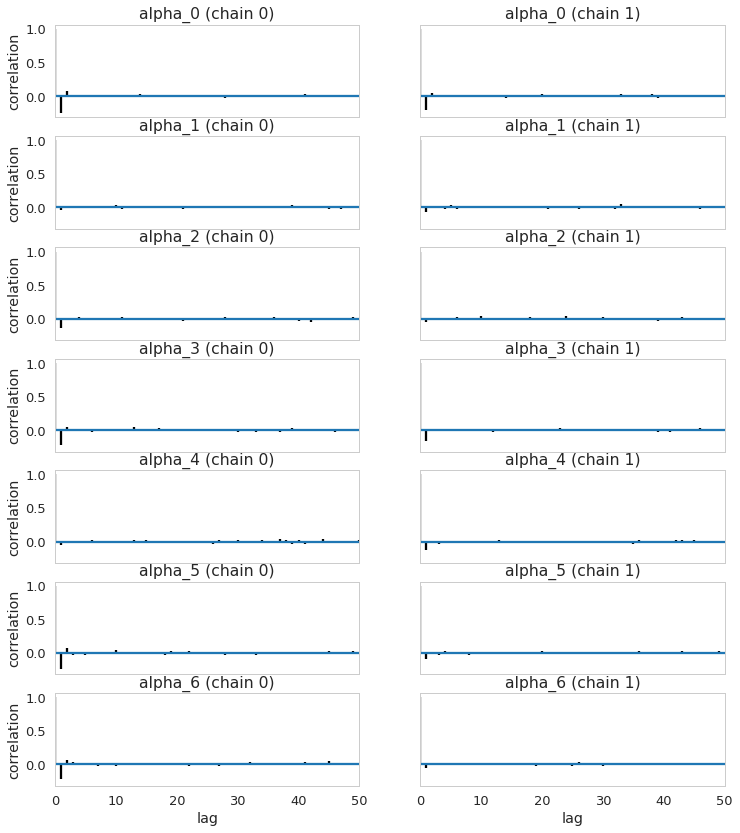

In [24]:
pm.autocorrplot(t2_edu, max_lag=50);

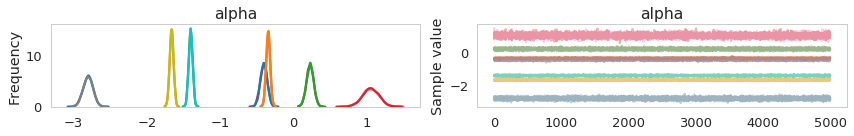

In [25]:
pm.traceplot(t2_edu);

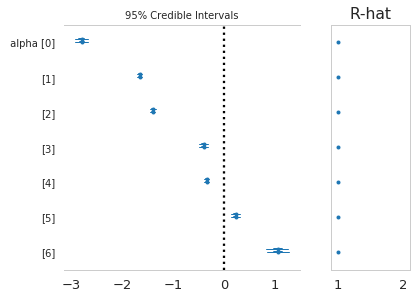

In [26]:
pm.forestplot(t2_edu);

In [27]:
print('Effective sample sizes')
print(pm.effective_n(t2_edu))

Effective sample sizes
{'alpha': array([ 10000.,  10000.,  10000.,  10000.,  10000.,  10000.,  10000.])}


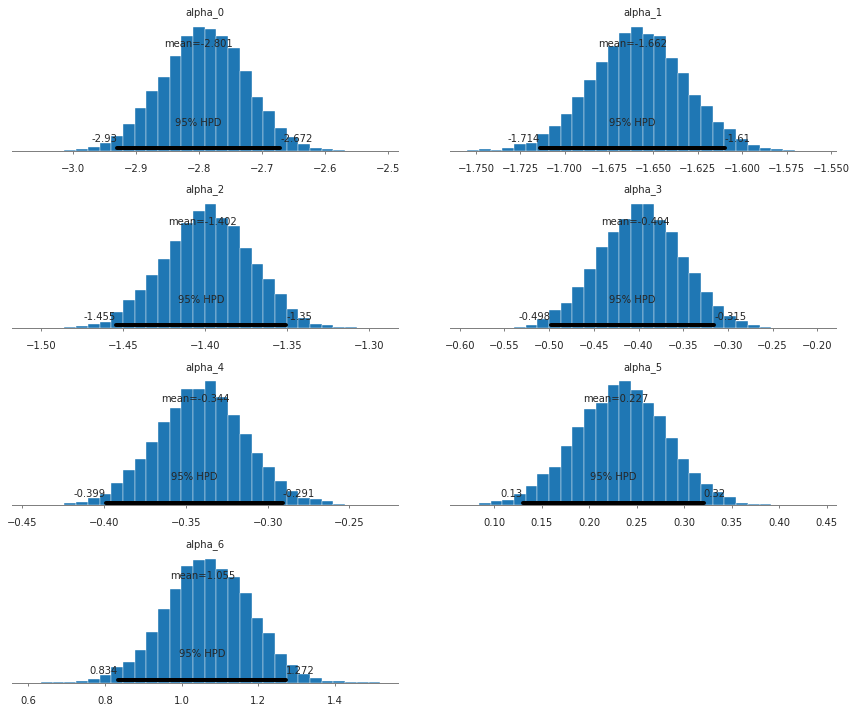

In [28]:
pm.plot_posterior(t2_edu);

The above tests suggest the convergence of the samplers.

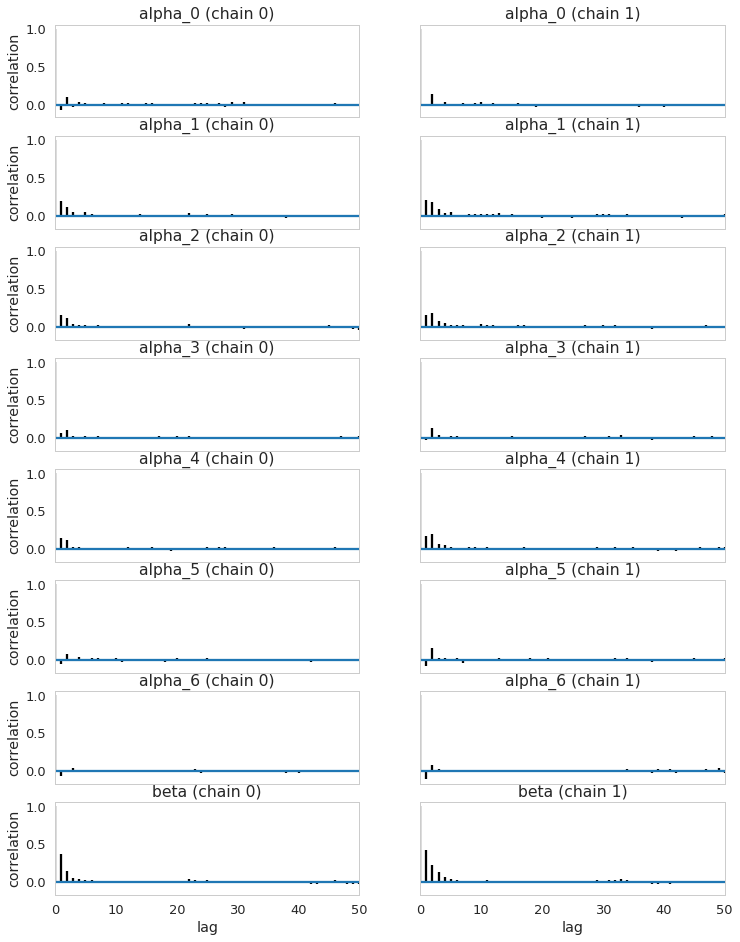

In [29]:
pm.autocorrplot(t2_edu_gender, max_lag=50);

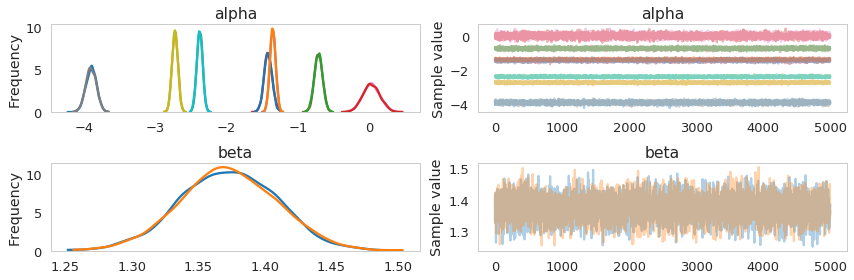

In [30]:
pm.traceplot(t2_edu_gender);

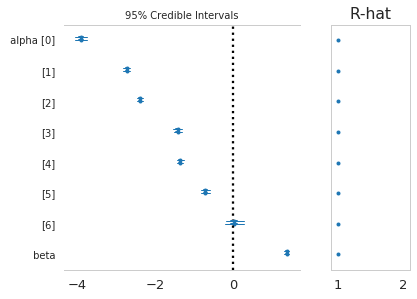

In [31]:
pm.forestplot(t2_edu_gender);

In [32]:
print('Effective sample sizes')
print(pm.effective_n(t2_edu_gender))

Effective sample sizes
{'alpha': array([  6867.,   4707.,   5199.,   7168.,   5449.,   8066.,  10000.]), 'beta': 3892.0}


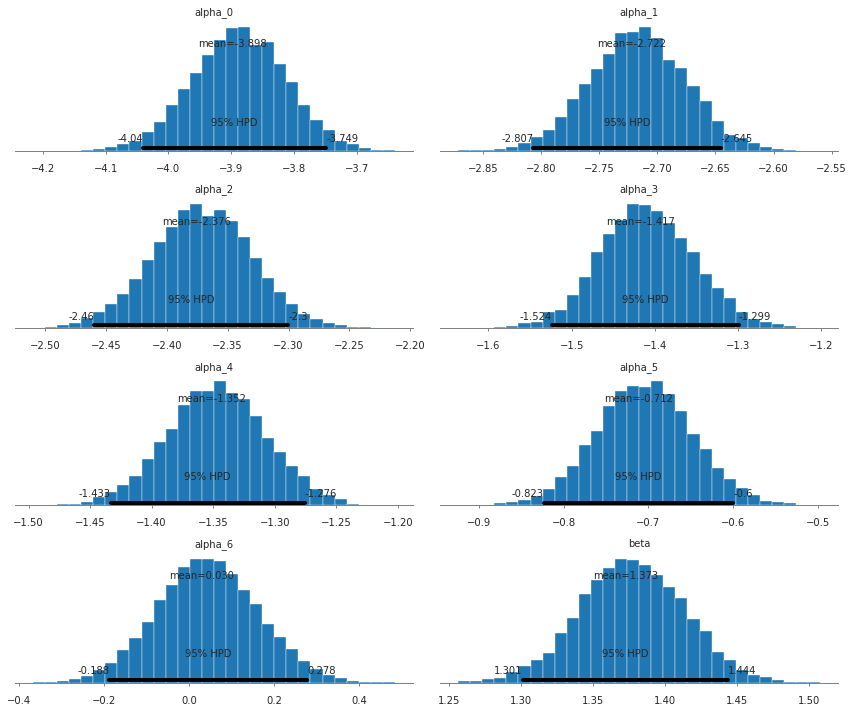

In [33]:
pm.plot_posterior(t2_edu_gender);

The above tests suggest the convergence of the samplers.

#### Replicate the analysis in 10.1.3 using your models; specifically, compute WAIC scores and make a plot like Figure 10.6 (posterior check) to see how well your model fits the data. Using your analysis, discuss the effect of gender on income, taking into account an individual's education.

In [34]:
compare_df2 = compare_models(['model_baseline', 'model_gender', 'model_edu', 'model_edu_gender'], \
                             [t2, t2_gender, t2_edu, t2_edu_gender], \
                             [m2, m2_gender, m2_edu, m2_edu_gender])
compare_df2

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
name,,,,,,,
model_edu_gender,123.55,6.27,0,1,5.69,0,1
model_edu,2837.4,697.3,2713.84,0,583.18,580.21,1
model_gender,4601.82,463.03,4478.27,0,1165.27,1164.5,1
model_baseline,6191.65,394.13,6068.1,0,1587.69,1586.64,1


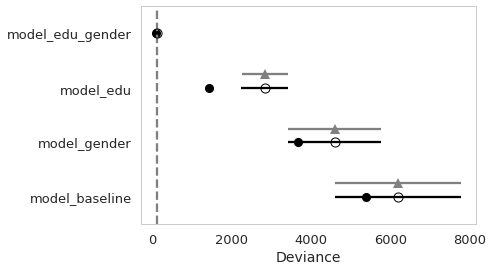

In [35]:
pm.compareplot(compare_df2);

The new models fit much better. The model with both gender and education is ranked first; the model with education only is ranked second and dWAIC is large, suggesting that gender matters a lot. WAIC scores indicate that both gender and education matter.

In [36]:
pm.summary(t2_edu_gender)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,-3.897587,0.074527,0.000815,-4.040040,-3.749155,6867.0,1.000041
alpha__1,-2.721967,0.041370,0.000575,-2.806938,-2.645321,4707.0,0.999908
alpha__2,-2.375911,0.040861,0.000541,-2.459516,-2.300110,5199.0,1.000099
alpha__3,-1.416670,0.056876,0.000648,-1.523575,-1.299069,7168.0,0.999941
alpha__4,-1.351655,0.040178,0.000519,-1.433404,-1.275560,5449.0,0.999900
alpha__5,-0.711722,0.056923,0.000640,-0.823087,-0.600073,8066.0,1.000042
alpha__6,0.030484,0.119199,0.001069,-0.187779,0.278134,10000.0,0.999989
beta,1.372903,0.036337,0.000569,1.300997,1.443587,3892.0,0.999906


Blue points are observed proportions; black dots, the tiny vertical black lines, and the black 
crosses represent posterior means, 2-sigma envelopes for posteriors, and 2-sigma envelopes for 
normalized posterior-predictives, respectively.


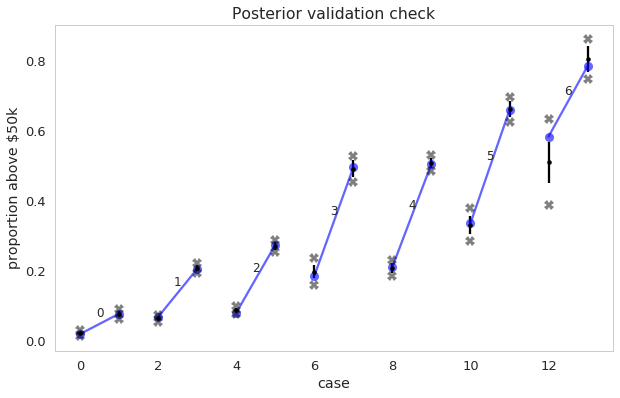

In [37]:
plt.figure(figsize=(10, 6))

for i in df2['edu_cat'].unique():
    plt.plot([2*i, 2*i+1], [df2['>50K'][2*i] / df2['total'][2*i], df2['>50K'][2*i+1] / df2['total'][2*i+1]], \
             'bo-', alpha=0.6)
    
    plt.text(2*i+0.4, (df2['>50K'][2*i] / df2['total'][2*i] + df2['>50K'][2*i+1] / df2['total'][2*i+1]) / 2 + 0.02,\
             df2['edu_cat'][2*i], fontsize=12)
    
    p_f = expit(t2_edu_gender['alpha'][:, i])
    p_m = expit(t2_edu_gender['alpha'][:, i] + t2_edu_gender['beta'])
    
    plt.errorbar([2*i, 2*i+1], [p_f.mean(), p_m.mean()], yerr=[2*p_f.std(), 2*p_m.std()], \
                 color='k', fmt='.')
    
    ppc_f = np.random.binomial(df2['total'][2*i], p_f) / df2['total'][2*i]
    ppc_m = np.random.binomial(df2['total'][2*i+1], p_m) / df2['total'][2*i+1]
    plt.plot([2*i, 2*i], [ppc_f.mean()-2*ppc_f.std(), ppc_f.mean()+2*ppc_f.std()], 'kX', alpha=0.5)
    plt.plot([2*i+1, 2*i+1], [ppc_m.mean()-2*ppc_m.std(), ppc_m.mean()+2*ppc_m.std()], 'kX', alpha=0.5)
    
plt.title('Posterior validation check');
plt.xlabel('case');
plt.ylabel('proportion above $50k');

print('''Blue points are observed proportions; black dots, the tiny vertical black lines, and the black 
crosses represent posterior means, 2-sigma envelopes for posteriors, and 2-sigma envelopes for 
normalized posterior-predictives, respectively.''')

As we can see, the model with gender and education fits the data very well; the 2-sigma envolopes of posteriors and normalized posterior predictives cover most data points. And we notice that the variance/uncertainty at the last education level is higher than others, which is presumably caused by lower number of total records at the education level.

The model reveals the male advantage on income at all education levels. If we compare the absolute values of proportions of high income, the male advantages are different at different education levels. The difference in proportions is low at the lowest education levels, and is high at professional, bachelors and masters degrees. But if we look at relative values, the male advantage at low education levels is still significant.